In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
!pip install kagglehub
import kagglehub
fcpercival_160k_spotify_songs_sorted_path = kagglehub.dataset_download('fcpercival/160k-spotify-songs-sorted')

print('Data source import complete.')


     -------------------------------------- 68.0/68.0 kB 529.9 kB/s eta 0:00:00
     -------------------------------------- 161.8/161.8 kB 1.1 MB/s eta 0:00:00
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
d:\music\Hybrid-Music-Recommendation-System\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🎧 MELODYMIND - HYBRID MUSIC RECOMMENDATION SYSTEM

Welcome to **MelodyMind**, a hybrid music recommendation system that blends **Content-Based Filtering** and **Collaborative Filtering** using **LightFM** for accurate and personalized recommendations.

---

## 🧠 What We'll Cover:
- **Setup & Imports**: Install and import required libraries.
- **Data Loading**: Load the music dataset.
- **Data Cleaning**: Clean and preprocess the dataset.
- **EDA**: Explore key statistics and visualizations.
- **Feature Engineering**: Prepare features for content-based filtering.
- **Content-Based Recommendation**: Recommend songs based on audio similarity.
- **Collaborative Filtering (LightFM)**:
  - Prepare interaction matrix
  - Train and evaluate the model
- **Hybrid Logic**: Combine both methods for better results.
- **Model Saving**: Save the trained model and required data.
- **Deployment**: Explain how to deploy the system as a web app.

## 🧠 Key Concepts:
- **Content-Based Filtering**: Recommends songs similar in features.
- **Collaborative Filtering**: Learns from user-item interactions.
- **Hybrid System**: Merges both approaches for improved recommendations.

---

## 1. Setup and Import Libraries

We will start by installing and importing all necessary libraries required for this project.


In [ ]:
!pip install --no-binary :all: lightfm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from scipy.sparse import csr_matrix # To handle sparse matrix from LightFM if needed

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

# For reproducibility
SEED = 42
np.random.seed(SEED)

ModuleNotFoundError: No module named 'matplotlib'

## 2. Data Loading
Load the main dataset containing track information and audio features.

In [5]:
try:
    # Main dataset with audio features and basic metadata
    data = pd.read_csv(r'/kaggle/input/160k-spotify-songs-sorted/data.csv', nrows=130009, low_memory=False)
    print("Dataset 'data.csv' loaded successfully with specified number of rows.")
    # Print the shape of the loaded DataFrame to confirm the number of rows and columns
    print(f"Loaded dataset shape: {data.shape}")

except FileNotFoundError:
    print("Error: Make sure 'data.csv' is in the current directory or the specified path is correct.")
    print("If you intended to use a Kaggle dataset, verify its path and existence.")
    # Re-raise the error to stop execution if the file is not found
    raise
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    raise

Error: Make sure 'data.csv' is in the current directory or the specified path is correct.
If you intended to use a Kaggle dataset, verify its path and existence.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/160k-spotify-songs-sorted/data.csv'

## 3. Data Cleaning
Clean the dataset by handling missing values, converting data types, and removing duplicates.

In [ ]:
# Drop rows with essential missing values
# Check if 'id' column exists, if not, maybe use another unique identifier if available
essential_cols = ['id', 'name', 'artists', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'year', 'duration_ms', 'popularity']
available_cols = [col for col in essential_cols if col in data.columns]
missing_cols = [col for col in essential_cols if col not in data.columns]
if missing_cols:
    print(f"Warning: The following expected columns are missing and won't be used for cleaning: {missing_cols}")

data.dropna(subset=available_cols, inplace=True)

# Rename columns for clarity
data.rename(columns={'name': 'track_name', 'artists': 'artist_name'}, inplace=True)

In [ ]:
def parse_artists(artists_str):
    try:
        import ast
        parsed_list = ast.literal_eval(artists_str)
        if isinstance(parsed_list, list):
            return parsed_list
        else:
             return [str(artists_str)]
    except (ValueError, SyntaxError):
        return [str(artists_str)]

data['artist_list'] = data['artist_name'].apply(parse_artists)
data['primary_artist'] = data['artist_list'].apply(lambda x: x[0] if isinstance(x, list) and x else 'Unknown')
data.drop_duplicates(subset=['track_name', 'primary_artist'], keep='first', inplace=True)

if 'year' in data.columns:
    data['year'] = data['year'].astype(int)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

print(f"Data shape after cleaning: {data.shape}")
print("Data cleaning finished (without external genre file).")
#print(data.head())
#print(data.info())

Data shape after cleaning: (118919, 21)
Data cleaning finished (without external genre file).


## 4. Exploratory Data Analysis (EDA)

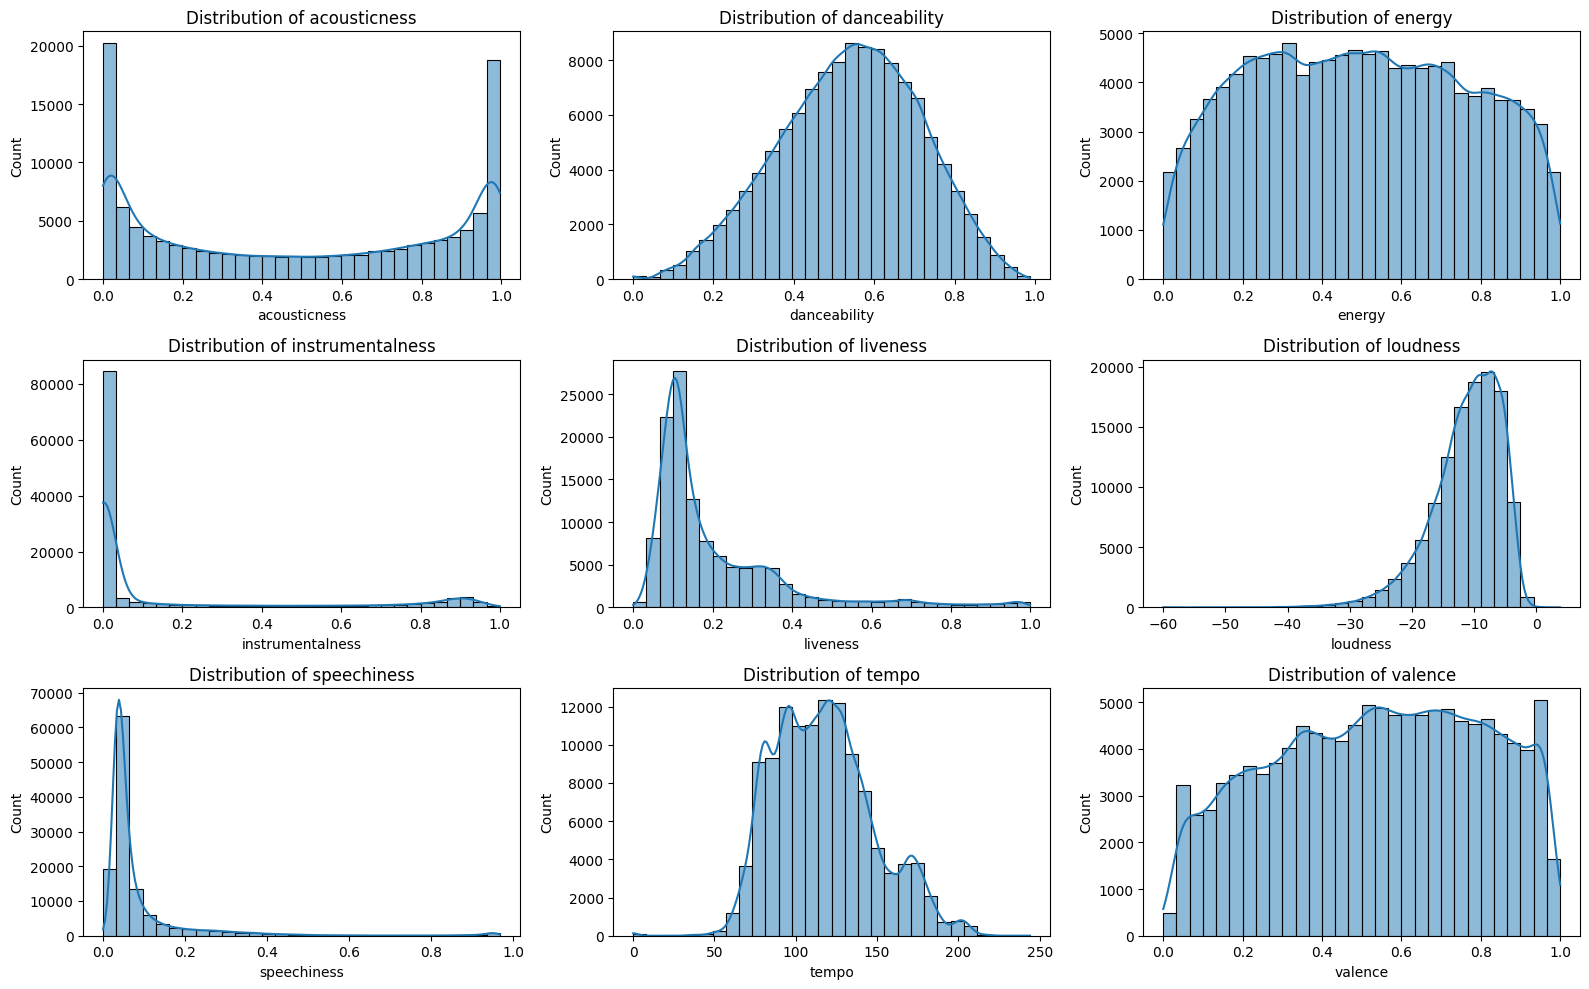

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

# Distribution of Key Audio Features
plt.figure(figsize=(16, 10))
for i, feature in enumerate(audio_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

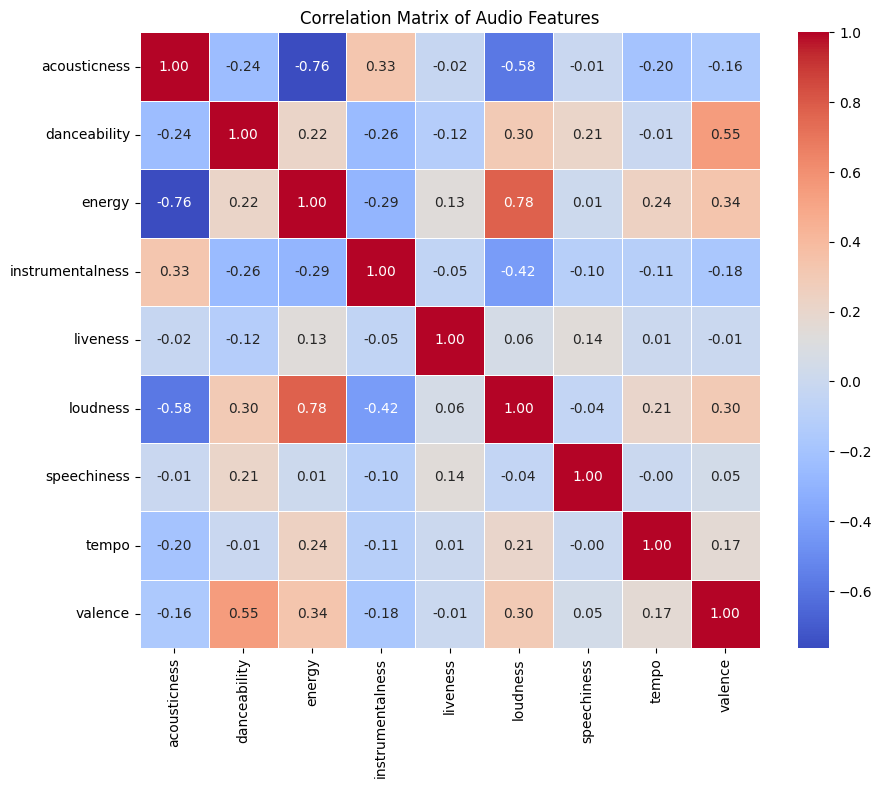

In [ ]:
# Correlation Heatmap of Audio Features
plt.figure(figsize=(10, 8))
correlation_matrix = data[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Audio Features')
plt.show()

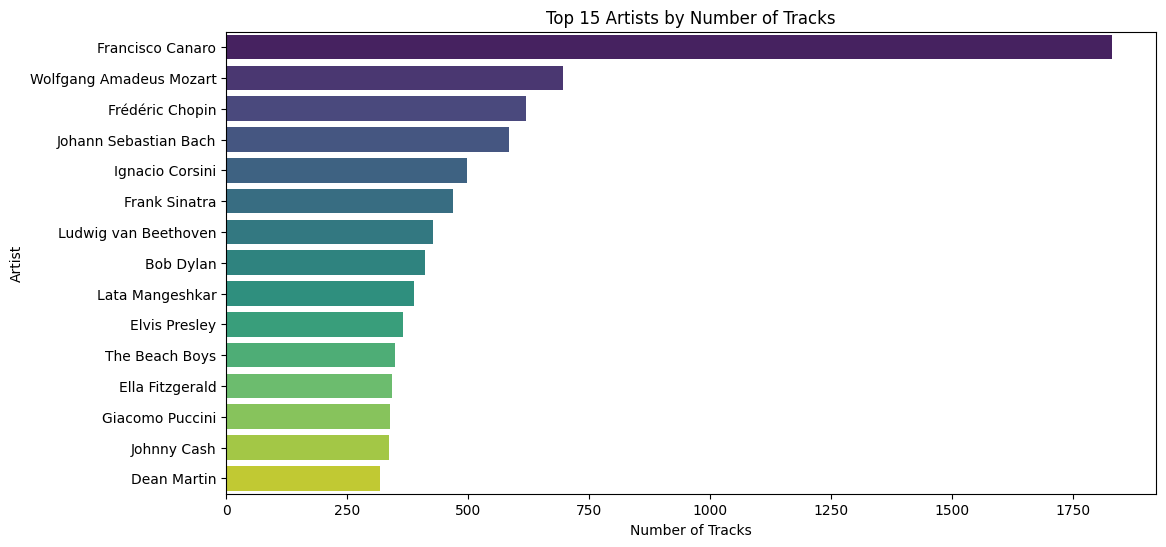

In [ ]:
# Top Artists
top_n = 15
top_artists = data['primary_artist'].value_counts().head(top_n)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title(f'Top {top_n} Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.show()

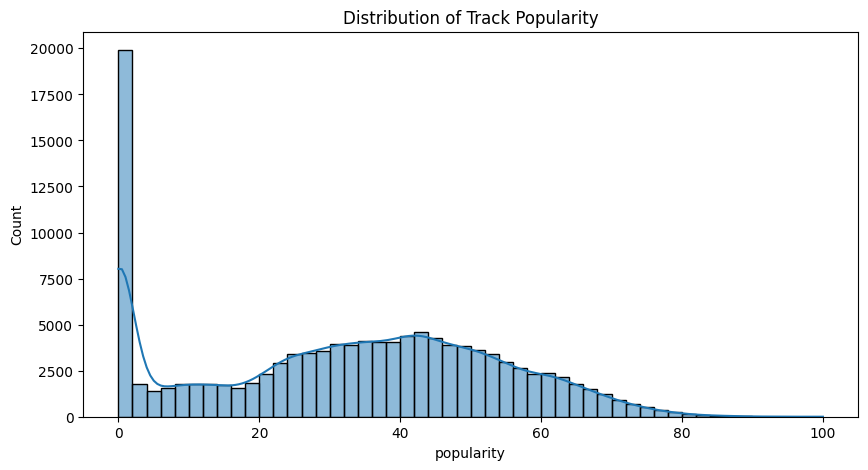

EDA Visualizations generated.


In [ ]:
# Popularity Distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['popularity'], kde=True, bins=50)
plt.title('Distribution of Track Popularity')
plt.show()

print("EDA Visualizations generated.")

## 5. Feature Engineering & Preprocessing for Content-Based
Prepare the numerical audio features by scaling them, which is necessary for calculating similarity measures like cosine similarity.     
Also, create mappings for easy lookup between track identifiers and DataFrame indices.

In [ ]:
# Select features for content-based filtering
content_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                    'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']

# Scale numerical features to range [0, 1] for cosine similarity
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[content_features])

# Create a dataframe with scaled features for easier lookup
scaled_df = pd.DataFrame(scaled_features, columns=content_features, index=data.index)

print("Features scaled successfully.")
print(scaled_df.head())

# Create mapping from track ID to index and track name to index for easy lookup
track_id_to_idx = pd.Series(data.index, index=data['id']).to_dict()
track_name_to_idx = pd.Series(data.index, index=data['track_name']).to_dict() # Note: track names might not be unique! Handle this later.
idx_to_track_name = pd.Series(data['track_name'], index=data.index).to_dict()
idx_to_artist_name = pd.Series(data['primary_artist'], index=data.index).to_dict()

Features scaled successfully.
   acousticness  danceability  energy  instrumentalness  liveness  loudness  \
0      0.527108      0.607287   0.540           0.00305  0.100100  0.754788   
1      0.228916      0.372470   0.480           0.70700  0.159159  0.757889   
2      0.100201      0.275304   0.684           0.01450  0.946947  0.787284   
3      0.185743      0.375506   0.545           0.58200  0.183183  0.793751   
4      0.000699      0.318826   0.970           0.00000  0.277277  0.865884   

   speechiness     tempo  valence  popularity  
0     0.033884  0.515783    0.547        0.26  
1     0.031612  0.615205    0.338        0.21  
2     0.052169  0.586171    0.279        0.41  
3     0.031715  0.615820    0.310        0.37  
4     0.105372  0.729515    0.423        0.48  


## 6. Content-Based Recommendation Logic
Implement the content-based filtering logic.     
This method recommends songs based on the similarity of their audio features to a given reference song.      
We calculate similarity on-demand to manage memory usage.

In [ ]:
def get_content_recommendations(track_name, all_features, data_df, idx_to_track, idx_to_artist, num_recommendations=10):

    matching_indices = data_df[data_df['track_name'] == track_name].index

    if not matching_indices.any():
        print(f"Warning: Track '{track_name}' not found in the dataset.")
        return []
    idx = matching_indices[0]
    target_features = all_features[idx].reshape(1, -1)
    sim_scores_vector = cosine_similarity(target_features, all_features)[0]
    sim_scores = list(enumerate(sim_scores_vector))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[1:num_recommendations + 1]]

    # Get track and artist names for recommended indices
    recommendations = [(idx_to_track.get(i, 'Unknown'), idx_to_artist.get(i, 'Unknown')) for i in top_indices]
    return recommendations

# Example Usage
example_song = "S' Agapo" # Make sure this exists in your data
if example_song in data['track_name'].values:
    print(f"\nContent-Based Recommendations for '{example_song}':")
    recommendations = get_content_recommendations(example_song, scaled_features, data, idx_to_track_name, idx_to_artist_name, num_recommendations=5)
    if recommendations:
        for i, (track, artist) in enumerate(recommendations):
            print(f"{i+1}. {track} by {artist}")
    else:
        print("Could not generate recommendations.")
else:
    print(f"Example song '{example_song}' not found, skipping example.")


Content-Based Recommendations for 'S' Agapo':
1. Sous Le Soleil Marocain by Perchicot
2. Girl Crazy: Treat Me Rough by George Gershwin
3. Kamalnayan Wale Ram by Jaganmoy Mitra
4. H trigona by Dimitris Arapakis
5. Concerto for 2 Violins in A Minor, RV 522: I. Allegro by Antonio Vivaldi


## 7. Collaborative Filtering (LightFM) - Data Preparation
Prepare the data for the LightFM collaborative filtering model.      
Since the dataset lacks explicit user interactions, we simulate them by treating each artist as a 'user' who has interacted with (e.g., 'liked') all of their tracks. This is a common approach for datasets without explicit user-item interaction data.

In [ ]:
# The dataset lacks explicit user IDs and interactions. We simulate them.
# Strategy: Assign each primary artist as a 'user' and assume they 'liked' all their tracks.
# This is a simplification. For a real-world scenario, you'd use actual user listen/rating data.

# Create unique IDs for users (artists) and items (tracks)
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

data['user_id'] = user_encoder.fit_transform(data['primary_artist'])
data['item_id'] = item_encoder.fit_transform(data['id']) # Use the original unique track 'id'

num_users = data['user_id'].nunique()
num_items = data['item_id'].nunique()

print(f"Number of unique 'users' (artists): {num_users}")
print(f"Number of unique items (tracks): {num_items}")

# Create interaction data: (user_id, item_id, rating/interaction_weight)
# Using 1 for interaction weight (implicit feedback)
interactions_df = data[['user_id', 'item_id']].copy()
interactions_df['interaction'] = 1 # Implicit feedback: artist is associated with the track

print("Simulated interaction data created:")
print(interactions_df.head())

# Build LightFM Dataset
# Use LightFM's Dataset class to handle mappings and matrix building
dataset = Dataset()
dataset.fit(users=interactions_df['user_id'].unique(),
            items=interactions_df['item_id'].unique())

# Build the interactions matrix
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    interactions_df[['user_id', 'item_id', 'interaction']].values
)

print("LightFM interaction matrix built:")
print(repr(interactions_matrix)) # Show sparse matrix representation

# Mappings from internal LightFM IDs back to our original IDs
# These are crucial for interpreting results
lightfm_mapping = dataset.mapping()
lightfm_user_id_map = lightfm_mapping[0]
lightfm_item_id_map = lightfm_mapping[2]

# Create reverse mappings (LightFM internal ID -> original ID)
# This requires iterating through the original mapping dictionaries
original_user_id_map = {v: k for k, v in lightfm_user_id_map.items()}
original_item_id_map = {v: k for k, v in lightfm_item_id_map.items()}

# Link original item ID back to track name and artist
item_id_to_details = pd.Series(
    list(zip(data['track_name'], data['primary_artist'])),
    index=data['item_id']
).to_dict()

Number of unique 'users' (artists): 17429
Number of unique items (tracks): 118919
Simulated interaction data created:
   user_id  item_id  interaction
0     9324    11895            1
1    16424    15321            1
2    16424    43202            1
3    16424    97032            1
4    15201    35094            1
LightFM interaction matrix built:
<COOrdinate sparse matrix of dtype 'int32'
	with 118919 stored elements and shape (17429, 118919)>


## 8. Collaborative Filtering (LightFM) - Model Training & Evaluation
Train the LightFM model using the prepared interaction matrix.     
We will use the WARP loss function, which is suitable for implicit feedback data. We will also perform a basic evaluation on the training data.

In [ ]:
print("\n Training LightFM model...")

# Initialize the model
# WARP loss is suitable for implicit feedback
lightfm_model = LightFM(loss='warp',
                        random_state=SEED,
                        learning_rate=0.03,
                        no_components=30) # Number of latent factors

# Train the model
# Use weights_matrix as sample_weight if you have varying interaction strengths
lightfm_model.fit(interactions_matrix,
                  epochs=10,         # Adjust epochs as needed
                  num_threads=4)     # Use multiple cores if available

print("LightFM model training complete.")


 Training LightFM model...
LightFM model training complete.


In [ ]:
# Evaluate the Model
print("\n Evaluating LightFM model (on training data)...")

# Use precision@k and recall@k
# k=10 means we look at the top 10 recommendations
precision = precision_at_k(lightfm_model, interactions_matrix, k=10).mean()
recall = recall_at_k(lightfm_model, interactions_matrix, k=10).mean()

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

print("\n LightFM model training and evaluation finished.")


 Evaluating LightFM model (on training data)...
Precision@10: 0.1379
Recall@10: 0.1864

 LightFM model training and evaluation finished.


## 9. Hybrid Recommendation Logic

In [ ]:
def get_lightfm_recommendations(user_id, model, num_recommendations=10):

    #Generates recommendations for a given user_id using a trained LightFM model.
    if user_id not in lightfm_user_id_map:
        print(f"Warning: User ID {user_id} not found in LightFM mapping.")
        return []

    internal_user_id = lightfm_user_id_map[user_id]
    all_item_indices = np.arange(num_items)
    scores = model.predict(internal_user_id, all_item_indices)
    top_internal_item_indices = np.argsort(-scores)[:num_recommendations]
    recommended_item_ids = [original_item_id_map[i] for i in top_internal_item_indices]
    recommendations = [item_id_to_details[item_id] for item_id in recommended_item_ids if item_id in item_id_to_details]
    return recommendations

In [ ]:
def hybrid_recommendation(user_id, reference_track_name, num_recommendations=10):

    #Generates hybrid recommendations combining content-based and collaborative filtering.

    print(f"\n Generating hybrid recommendations for User ID: {user_id}, based on track: '{reference_track_name}'")
    content_recs = get_content_recommendations(reference_track_name, scaled_features, data, idx_to_track_name, idx_to_artist_name, num_recommendations=num_recommendations * 2)
    collab_recs = get_lightfm_recommendations(user_id, lightfm_model, num_recommendations=num_recommendations * 2)

    combined_recs = {}
    for track, artist in collab_recs:
        if (track, artist) not in combined_recs:
            combined_recs[(track, artist)] = "collab"

    for track, artist in content_recs:
        if (track, artist) not in combined_recs:
            combined_recs[(track, artist)] = "content"

    final_recommendations = list(combined_recs.keys())
    return final_recommendations[:num_recommendations]


# Example Usage
example_user_id = data['user_id'].iloc[500]
example_user_artist = data[data['user_id'] == example_user_id]['primary_artist'].iloc[0]

example_ref_track = "Come As You Are"

print(f"\nHybrid Recommendation Example for User: {example_user_artist} (ID: {example_user_id})\n")
hybrid_recs = hybrid_recommendation(user_id=example_user_id,
                                    reference_track_name=example_ref_track,
                                    num_recommendations=10)

if hybrid_recs:
    print("Top Hybrid Recommendations:")
    for i, (track, artist) in enumerate(hybrid_recs):
        print(f"{i+1}. {track} by {artist}")
else:
    print("Could not generate hybrid recommendations (maybe user/track not found?).")


Hybrid Recommendation Example for User: Bee Gees (ID: 1425)


 Generating hybrid recommendations for User ID: 1425, based on track: 'Come As You Are'
Top Hybrid Recommendations:
1. Massachusetts - Live At The MGM Grand by Bee Gees
2. Closer Than Close by Bee Gees
3. Emotion by Bee Gees
4. In My Own Time by Bee Gees
5. Stayin’ Alive - Serban Mix by Bee Gees
6. Please Read Me by Bee Gees
7. Every Christian Lion Hearted Man Will Show You by Bee Gees
8. I.O.I.O. by Bee Gees
9. (Our Love) Don't Throw It All Away by Bee Gees
10. Melody Fair by Bee Gees


## 10. Save Model Components

In [ ]:
import pickle

print(f"Debug: Type of scaled_features before saving: {type(scaled_features)}")
if isinstance(scaled_features, np.ndarray):
    print(f"Debug: Shape of scaled_features before saving: {scaled_features.shape}")
else:
    print("Debug: scaled_features is not a NumPy array (might be None or something else).")


save_path = "/kaggle/working/music_recommender_components.pkl"

content_features_list = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                         'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']

components = {
    'lightfm_model': lightfm_model,
    'scaler': scaler,
    'scaled_features': scaled_features,
    'data': data[['id', 'track_name', 'primary_artist', 'user_id', 'item_id', 'year'] + content_features_list].copy(),
    'user_encoder': user_encoder,
    'item_encoder': item_encoder,
    'lightfm_user_id_map': lightfm_user_id_map,
    'lightfm_item_id_map': lightfm_item_id_map,
    'original_user_id_map': original_user_id_map,
    'original_item_id_map': original_item_id_map,
    'item_id_to_details': item_id_to_details,
    'idx_to_track_name': idx_to_track_name,
    'idx_to_artist_name': idx_to_artist_name
}

try:
    with open(save_path, 'wb') as f:
        pickle.dump(components, f)
    print(f"All components saved successfully to: {save_path}")
except Exception as e:
    print(f"Error saving components: {e}")

try:
    with open(save_path, 'rb') as f:
        loaded_components = pickle.load(f)
    print("Components loaded successfully (test passed).")
    # Optional: Verify some loaded components
    print(f"Loaded scaled_features shape: {loaded_components['scaled_features'].shape}")
    print(f"Loaded data shape: {loaded_components['data'].shape}")
except Exception as e:
    print(f"Error loading saved components: {e}")

Debug: Type of scaled_features before saving: <class 'numpy.ndarray'>
Debug: Shape of scaled_features before saving: (118919, 10)
All components saved successfully to: /kaggle/working/music_recommender_components.pkl
Components loaded successfully (test passed).
Loaded scaled_features shape: (118919, 10)
Loaded data shape: (118919, 16)


## 🚀 11. Deployment (Quick Guide)

Make your hybrid music recommender interactive by deploying it as a **Streamlit app**! 🎵💻

#### 🛠️ Steps to Deploy:

1. **Create `music_app.py`**  
   Build a UI using Streamlit that loads `music_recommender_components.pkl` and calls the recommendation functions.

2. **Save Model Components**  
   After training, download `music_recommender_components.pkl` from `/kaggle/working/`.

3. **install requirements**  

4. **Set Up & Run**  
   - Put all files in one folder.
   - Activate virtual env:  
     `.\lightfm310-env\Scripts\activate` *(Windows)*  
     `source venv/bin/activate` *(macOS/Linux)*  
   - Install libs: `pip install -r requirements.txt`  
   - Launch app: `streamlit run music_app.py`

# Your music recommender is now live! 🎶🌐
